In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [2]:
R103_means = pd.read_csv('./datasets/fieldData_R103_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_means = pd.read_csv('./datasets/fieldData_R503_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_means = pd.read_csv('./datasets/fieldData_R104_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

R103_scales = pd.read_csv('./datasets/fieldData_R103_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_scales = pd.read_csv('./datasets/fieldData_R503_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_scales = pd.read_csv('./datasets/fieldData_R104_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

FileNotFoundError: [Errno 2] No such file or directory: './datasets/fieldData_R103_means.txt'

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000607,-0.001033,0.001586,0.003769,-0.000243,-0.000310,0.001519,-0.004942,-0.002082,...,-0.004942,0.000056,-0.001784,-0.134213,-0.010852,0.009912,-0.153644,-0.045258,-0.150407,-0.232084
1,-1.027122,0.048423,-0.002944,-0.000262,0.021788,-0.000289,-0.000408,0.001519,-0.017760,-0.002090,...,-0.017760,0.000042,-0.015981,-0.134199,-0.010853,0.009911,-0.153644,-0.045258,-0.150407,-0.191414
2,-1.027122,0.146858,-0.000820,0.001179,0.005336,0.000219,0.000182,0.001882,-0.003509,-0.002079,...,-0.003509,0.000060,-0.004908,-0.133998,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.044781
3,-1.027122,0.095208,-0.000137,0.002144,-0.003282,-0.000302,-0.000333,0.001519,0.001063,-0.002076,...,0.001063,0.000066,0.002495,-0.133893,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.088803
4,-1.027122,0.078927,-0.000084,0.001453,-0.000148,-0.000061,-0.000199,0.001519,0.001425,-0.002077,...,0.001425,0.000064,-0.002813,-0.133738,-0.010855,0.009909,-0.153644,-0.045258,-0.150406,-0.099000


In [4]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(26697608, 23)

In [5]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [6]:
M1.shape, M2.shape

((26697608, 10), (26697608, 13))

In [7]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [85]:
scale = R104_scales["Cs"]
mean = R104_means["Cs"]
dt = M4_104
dt_name = namestr(M4_104, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [9]:
dt.head()

,G1,G2,G3,G4,G5,G6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-0.000859,0.001333,0.000589,0.000236,-0.001709,0.000490,-0.117743,-0.001035,0.000682,-0.143908,-0.005119,-0.143157,-1.929617
1,0.007403,0.001420,0.000656,0.000236,-0.004601,0.000669,-0.117742,-0.001035,0.000682,-0.143908,-0.005119,-0.143157,-0.183021
2,0.015995,0.001564,0.000896,0.000236,-0.008244,-0.000488,-0.117735,-0.001036,0.000682,-0.143908,-0.005119,-0.143157,-0.124142
3,0.011368,0.001738,0.001067,0.000236,-0.001409,-0.001457,-0.117709,-0.001036,0.000681,-0.143908,-0.005119,-0.143157,-0.258416
4,-0.009122,0.000399,0.000139,-0.000411,0.004366,-0.001645,-0.117683,-0.001036,0.000681,-0.143908,-0.005118,-0.143157,0.106165


In [10]:
#dt.to_csv(f'./{dt_name}.txt', sep=' ', index=False, encoding='utf-8', header=False)

In [11]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [12]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((17552029, 13), 11234695, 2807427, 3509907)

In [13]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [14]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 3.5163e-02, -8.0394e-03, -1.9024e-03, -4.2935e-03,  1.9647e-02,
        -7.3606e-03, -1.1723e-01, -1.0461e-03,  7.3754e-04, -1.4345e-01,
        -4.8394e-03, -1.4298e-01, -8.1433e-01], dtype=torch.float64)

In [15]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [16]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [17]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_layers, neurons_per_layer):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        encoder_layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            encoder_layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(neurons_per_layer[-1], latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_size, neurons_per_layer[-1]))
        decoder_layers.append(nn.ReLU())

        for i in range(hidden_layers - 1, 0, -1):
            decoder_layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i - 1]))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(neurons_per_layer[0], 1))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)

        # Decode
        decoded = self.decoder(encoded)

        return decoded


In [18]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

In [19]:
#model = Autoencoder(input_size, latent_size, hidden_layers, neurons_per_layer)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

In [21]:
#criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
device = torch.device("cuda")
model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [23]:
class EarlyStopper:
    def __init__(self, patience=1, path=None):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, model_stat, val_loss):
        if val_loss < self.min_val_loss:
            torch.save(model_stat, self.path)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + sys_epsilon):
            self.counter += 1
            if self.counter >= self.patience:
                print('+++ Early Stopping is reached! +++')
                return True
        return False

In [24]:
epochs = 6000
best = 1e6
PATH = f"./best_model_{dt_name}.pt"

early_stopper = EarlyStopper(patience=50, path=PATH)
                             
for epoch in range(epochs):
    model.train()
    Loss_train = 0 
    Loss_val = 0
    coeff_train = 0
    coeff_val = 0
    with tqdm(train_loader, unit="batch") as trainer:
        for batch in trainer:
            trainer.set_description("Train")
            train_feat = batch[:, 0:-1].to(device)
            train_labs = batch[:, -1].to(device)
            train_pred = model(train_feat).squeeze()
            train_loss = torch.nn.functional.mse_loss(train_pred, train_labs)
            train_coef = coeff_determination(train_labs, train_labs) 

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            Loss_train += train_loss.item()
            coeff_train += train_coef

        Loss_train /= batch_sz_trn
        coeff_train /= batch_sz_trn

    model.eval()
    with tqdm(val_loader, unit="batch") as validator:
        for batch in validator:
            validator.set_description("Valdt")
            val_feat = batch[:, 0:-1].to(device)
            val_labs = batch[:, -1].to(device)
            val_pred = model(val_feat).squeeze()
            val_loss = torch.nn.functional.mse_loss(val_pred, val_labs)
            val_coef = coeff_determination(val_labs, val_labs) 

            Loss_val += val_loss.item()
            coeff_val += val_coef

        Loss_val /= batch_sz_val
        coeff_val /= batch_sz_val
    
    if early_stopper.early_stop(model.state_dict(), Loss_val):             
        break
        
    print(f"Epoch: {epoch} / {epochs}, \n Train -- Loss: {Loss_train}, Coeff: {coeff_train} \n Val   -- Loss: {Loss_val}, Coeff: {coeff_val} \n\n")

Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.17batch/s]


Epoch: 0 / 6000, 
 Train -- Loss: 0.6223813256101323, Coeff: 0.669677734375 
 Val   -- Loss: 2.353805321026261, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.96batch/s]


Epoch: 1 / 6000, 
 Train -- Loss: 0.6066980500418006, Coeff: 0.669677734375 
 Val   -- Loss: 2.3181211950565426, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.21batch/s]


Epoch: 2 / 6000, 
 Train -- Loss: 0.5998018649233893, Coeff: 0.669677734375 
 Val   -- Loss: 2.3046816936417063, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.42batch/s]


Epoch: 3 / 6000, 
 Train -- Loss: 0.5939638229764839, Coeff: 0.669677734375 
 Val   -- Loss: 2.2794590190571036, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.85batch/s]


Epoch: 4 / 6000, 
 Train -- Loss: 0.5891169316530369, Coeff: 0.669677734375 
 Val   -- Loss: 2.2558538862055406, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.83batch/s]


Epoch: 5 / 6000, 
 Train -- Loss: 0.5855060351260648, Coeff: 0.669677734375 
 Val   -- Loss: 2.265980476595093, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.96batch/s]


Epoch: 6 / 6000, 
 Train -- Loss: 0.5830325994885495, Coeff: 0.669677734375 
 Val   -- Loss: 2.247522330320236, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.12batch/s]


Epoch: 7 / 6000, 
 Train -- Loss: 0.581086988551249, Coeff: 0.669677734375 
 Val   -- Loss: 2.25199994622655, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.21batch/s]


Epoch: 8 / 6000, 
 Train -- Loss: 0.5793766674369437, Coeff: 0.669677734375 
 Val   -- Loss: 2.2468873908959495, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.78batch/s]


Epoch: 9 / 6000, 
 Train -- Loss: 0.5777671810525378, Coeff: 0.669677734375 
 Val   -- Loss: 2.233263795316538, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.01batch/s]


Epoch: 10 / 6000, 
 Train -- Loss: 0.5763517395987374, Coeff: 0.669677734375 
 Val   -- Loss: 2.2358237656859163, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.03batch/s]


Epoch: 11 / 6000, 
 Train -- Loss: 0.5751928095726595, Coeff: 0.669677734375 
 Val   -- Loss: 2.2357351319141427, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.91batch/s]


Epoch: 12 / 6000, 
 Train -- Loss: 0.5737132073109202, Coeff: 0.669677734375 
 Val   -- Loss: 2.2328057842674505, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.02batch/s]


Epoch: 13 / 6000, 
 Train -- Loss: 0.572540314800677, Coeff: 0.669677734375 
 Val   -- Loss: 2.2705429391255976, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.33batch/s]


Epoch: 14 / 6000, 
 Train -- Loss: 0.5717557363596916, Coeff: 0.669677734375 
 Val   -- Loss: 2.21199887755059, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.37batch/s]


Epoch: 15 / 6000, 
 Train -- Loss: 0.5705619265501459, Coeff: 0.669677734375 
 Val   -- Loss: 2.219567948737515, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.83batch/s]


Epoch: 16 / 6000, 
 Train -- Loss: 0.569582960140722, Coeff: 0.669677734375 
 Val   -- Loss: 2.2227680167729975, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.52batch/s]


Epoch: 17 / 6000, 
 Train -- Loss: 0.5686922392599579, Coeff: 0.669677734375 
 Val   -- Loss: 2.2196325303570124, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.24batch/s]


Epoch: 18 / 6000, 
 Train -- Loss: 0.567381774977035, Coeff: 0.669677734375 
 Val   -- Loss: 2.215389256203486, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.73batch/s]


Epoch: 19 / 6000, 
 Train -- Loss: 0.5667099739487786, Coeff: 0.669677734375 
 Val   -- Loss: 2.2127736363177375, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.40batch/s]


Epoch: 20 / 6000, 
 Train -- Loss: 0.5660186158147774, Coeff: 0.669677734375 
 Val   -- Loss: 2.2259439731692687, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.20batch/s]


Epoch: 21 / 6000, 
 Train -- Loss: 0.5653268511551465, Coeff: 0.669677734375 
 Val   -- Loss: 2.2162297156090416, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.90batch/s]


Epoch: 22 / 6000, 
 Train -- Loss: 0.564564174541512, Coeff: 0.669677734375 
 Val   -- Loss: 2.195964267066436, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.02batch/s]


Epoch: 23 / 6000, 
 Train -- Loss: 0.5640546346406486, Coeff: 0.669677734375 
 Val   -- Loss: 2.205390922669949, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.38batch/s]


Epoch: 24 / 6000, 
 Train -- Loss: 0.5627163613603162, Coeff: 0.669677734375 
 Val   -- Loss: 2.224147467121413, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.75batch/s]


Epoch: 25 / 6000, 
 Train -- Loss: 0.5634162439643104, Coeff: 0.669677734375 
 Val   -- Loss: 2.194902879806097, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.64batch/s]


Epoch: 26 / 6000, 
 Train -- Loss: 0.5617650321729812, Coeff: 0.669677734375 
 Val   -- Loss: 2.1959190538778097, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.31batch/s]


Epoch: 27 / 6000, 
 Train -- Loss: 0.5610384472086147, Coeff: 0.669677734375 
 Val   -- Loss: 2.205251818575711, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.50batch/s]


Epoch: 28 / 6000, 
 Train -- Loss: 0.5608391409053032, Coeff: 0.669677734375 
 Val   -- Loss: 2.200425186304036, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.31batch/s]


Epoch: 29 / 6000, 
 Train -- Loss: 0.5599842091076441, Coeff: 0.669677734375 
 Val   -- Loss: 2.2078839787084408, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.41batch/s]


Epoch: 30 / 6000, 
 Train -- Loss: 0.5592466130671175, Coeff: 0.669677734375 
 Val   -- Loss: 2.197557660446334, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.74batch/s]


Epoch: 31 / 6000, 
 Train -- Loss: 0.5594943645082171, Coeff: 0.669677734375 
 Val   -- Loss: 2.2118361543392457, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.86batch/s]


Epoch: 32 / 6000, 
 Train -- Loss: 0.559015053763386, Coeff: 0.669677734375 
 Val   -- Loss: 2.2062710197792925, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.47batch/s]


Epoch: 33 / 6000, 
 Train -- Loss: 0.5576053977958224, Coeff: 0.669677734375 
 Val   -- Loss: 2.1952639895782684, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 243.41batch/s]


Epoch: 34 / 6000, 
 Train -- Loss: 0.5570030617221412, Coeff: 0.669677734375 
 Val   -- Loss: 2.1947196467265924, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.53batch/s]


Epoch: 35 / 6000, 
 Train -- Loss: 0.5576579143999123, Coeff: 0.669677734375 
 Val   -- Loss: 2.186134926412006, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.66batch/s]


Epoch: 36 / 6000, 
 Train -- Loss: 0.5564607690679066, Coeff: 0.669677734375 
 Val   -- Loss: 2.1865719619597783, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.69batch/s]


Epoch: 37 / 6000, 
 Train -- Loss: 0.5567103912277878, Coeff: 0.669677734375 
 Val   -- Loss: 2.1947145305882776, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.19batch/s]


Epoch: 38 / 6000, 
 Train -- Loss: 0.5564491109096306, Coeff: 0.669677734375 
 Val   -- Loss: 2.191011912205829, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.70batch/s]


Epoch: 39 / 6000, 
 Train -- Loss: 0.5557573201563378, Coeff: 0.669677734375 
 Val   -- Loss: 2.1973178927212533, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.04batch/s]


Epoch: 40 / 6000, 
 Train -- Loss: 0.555393056765511, Coeff: 0.669677734375 
 Val   -- Loss: 2.201224177559546, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.77batch/s]


Epoch: 41 / 6000, 
 Train -- Loss: 0.554456004281541, Coeff: 0.669677734375 
 Val   -- Loss: 2.187683028347542, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.49batch/s]


Epoch: 42 / 6000, 
 Train -- Loss: 0.5547243917686103, Coeff: 0.669677734375 
 Val   -- Loss: 2.1950626029250517, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.11batch/s]


Epoch: 43 / 6000, 
 Train -- Loss: 0.5544177486035772, Coeff: 0.669677734375 
 Val   -- Loss: 2.179904300730175, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.19batch/s]


Epoch: 44 / 6000, 
 Train -- Loss: 0.5539845732518999, Coeff: 0.669677734375 
 Val   -- Loss: 2.191408343500154, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.09batch/s]


Epoch: 45 / 6000, 
 Train -- Loss: 0.5535490076312567, Coeff: 0.669677734375 
 Val   -- Loss: 2.1842303434005674, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.79batch/s]


Epoch: 46 / 6000, 
 Train -- Loss: 0.5527254867324288, Coeff: 0.669677734375 
 Val   -- Loss: 2.1990835026284703, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 239.09batch/s]


Epoch: 47 / 6000, 
 Train -- Loss: 0.5522675368867614, Coeff: 0.669677734375 
 Val   -- Loss: 2.1916920793664816, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.16batch/s]


Epoch: 48 / 6000, 
 Train -- Loss: 0.5526536680700948, Coeff: 0.669677734375 
 Val   -- Loss: 2.1816696434747564, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.80batch/s]


Epoch: 49 / 6000, 
 Train -- Loss: 0.5518893574312367, Coeff: 0.669677734375 
 Val   -- Loss: 2.18038810568759, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.01batch/s]


Epoch: 50 / 6000, 
 Train -- Loss: 0.5523621111176407, Coeff: 0.669677734375 
 Val   -- Loss: 2.19153335935015, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.43batch/s]


Epoch: 51 / 6000, 
 Train -- Loss: 0.5514411687559712, Coeff: 0.669677734375 
 Val   -- Loss: 2.1896489952956926, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 239.03batch/s]


Epoch: 52 / 6000, 
 Train -- Loss: 0.5516989350443325, Coeff: 0.669677734375 
 Val   -- Loss: 2.1894714214663304, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.93batch/s]


Epoch: 53 / 6000, 
 Train -- Loss: 0.5512744230538615, Coeff: 0.669677734375 
 Val   -- Loss: 2.1772082234802, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.31batch/s]


Epoch: 54 / 6000, 
 Train -- Loss: 0.5500821076505237, Coeff: 0.669677734375 
 Val   -- Loss: 2.1740321455654925, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.07batch/s]


Epoch: 55 / 6000, 
 Train -- Loss: 0.5500307284324253, Coeff: 0.669677734375 
 Val   -- Loss: 2.1809595285063574, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.19batch/s]


Epoch: 56 / 6000, 
 Train -- Loss: 0.5500334244232611, Coeff: 0.669677734375 
 Val   -- Loss: 2.191122569045778, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.63batch/s]


Epoch: 57 / 6000, 
 Train -- Loss: 0.5496435757859615, Coeff: 0.669677734375 
 Val   -- Loss: 2.1844427706484084, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.93batch/s]


Epoch: 58 / 6000, 
 Train -- Loss: 0.5499257809708058, Coeff: 0.669677734375 
 Val   -- Loss: 2.175008582021906, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.51batch/s]


Epoch: 59 / 6000, 
 Train -- Loss: 0.5491681009382091, Coeff: 0.669677734375 
 Val   -- Loss: 2.1737431551690154, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.45batch/s]


Epoch: 60 / 6000, 
 Train -- Loss: 0.5493193677475818, Coeff: 0.669677734375 
 Val   -- Loss: 2.1707312905309086, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.95batch/s]


Epoch: 61 / 6000, 
 Train -- Loss: 0.5484858690422936, Coeff: 0.669677734375 
 Val   -- Loss: 2.1922029411715567, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.24batch/s]


Epoch: 62 / 6000, 
 Train -- Loss: 0.5489217761745676, Coeff: 0.669677734375 
 Val   -- Loss: 2.184336208646612, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.01batch/s]


Epoch: 63 / 6000, 
 Train -- Loss: 0.5482444591773229, Coeff: 0.669677734375 
 Val   -- Loss: 2.182538363644365, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.29batch/s]


Epoch: 64 / 6000, 
 Train -- Loss: 0.5482798670944363, Coeff: 0.669677734375 
 Val   -- Loss: 2.193617605313346, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.34batch/s]


Epoch: 65 / 6000, 
 Train -- Loss: 0.5479182435066701, Coeff: 0.669677734375 
 Val   -- Loss: 2.1766998643324733, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.88batch/s]


Epoch: 66 / 6000, 
 Train -- Loss: 0.5478010967945117, Coeff: 0.669677734375 
 Val   -- Loss: 2.177240134466625, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.02batch/s]


Epoch: 67 / 6000, 
 Train -- Loss: 0.5471948311423607, Coeff: 0.669677734375 
 Val   -- Loss: 2.1959487785789493, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.33batch/s]


Epoch: 68 / 6000, 
 Train -- Loss: 0.5472451335511117, Coeff: 0.669677734375 
 Val   -- Loss: 2.1724548648438096, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.13batch/s]


Epoch: 69 / 6000, 
 Train -- Loss: 0.5470209333955235, Coeff: 0.669677734375 
 Val   -- Loss: 2.181224326690104, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.20batch/s]


Epoch: 70 / 6000, 
 Train -- Loss: 0.5463201060963694, Coeff: 0.669677734375 
 Val   -- Loss: 2.17028259268515, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.50batch/s]


Epoch: 71 / 6000, 
 Train -- Loss: 0.5461364642360248, Coeff: 0.669677734375 
 Val   -- Loss: 2.1801490808776984, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.48batch/s]


Epoch: 72 / 6000, 
 Train -- Loss: 0.5458711851293282, Coeff: 0.669677734375 
 Val   -- Loss: 2.1702767302884234, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.95batch/s]


Epoch: 73 / 6000, 
 Train -- Loss: 0.5463145988312629, Coeff: 0.669677734375 
 Val   -- Loss: 2.1765386450185713, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.69batch/s]


Epoch: 74 / 6000, 
 Train -- Loss: 0.5462848341634228, Coeff: 0.669677734375 
 Val   -- Loss: 2.1896680325531896, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.73batch/s]


Epoch: 75 / 6000, 
 Train -- Loss: 0.5455498249271863, Coeff: 0.669677734375 
 Val   -- Loss: 2.1727592169216488, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.19batch/s]


Epoch: 76 / 6000, 
 Train -- Loss: 0.5463222466702972, Coeff: 0.669677734375 
 Val   -- Loss: 2.1762271635604167, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.16batch/s]


Epoch: 77 / 6000, 
 Train -- Loss: 0.5453927567326609, Coeff: 0.669677734375 
 Val   -- Loss: 2.1825715891679636, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.93batch/s]


Epoch: 78 / 6000, 
 Train -- Loss: 0.5446834285995186, Coeff: 0.669677734375 
 Val   -- Loss: 2.1659529120021044, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.20batch/s]


Epoch: 79 / 6000, 
 Train -- Loss: 0.5444517132204564, Coeff: 0.669677734375 
 Val   -- Loss: 2.1754021579657192, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.57batch/s]


Epoch: 80 / 6000, 
 Train -- Loss: 0.5445963594032651, Coeff: 0.669677734375 
 Val   -- Loss: 2.2105643947462594, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.42batch/s]


Epoch: 81 / 6000, 
 Train -- Loss: 0.5448477824353686, Coeff: 0.669677734375 
 Val   -- Loss: 2.1995952715129397, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.70batch/s]


Epoch: 82 / 6000, 
 Train -- Loss: 0.5442434241723751, Coeff: 0.669677734375 
 Val   -- Loss: 2.1715847284171095, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.85batch/s]


Epoch: 83 / 6000, 
 Train -- Loss: 0.5438696792955079, Coeff: 0.669677734375 
 Val   -- Loss: 2.1799357275509252, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.30batch/s]


Epoch: 84 / 6000, 
 Train -- Loss: 0.5442674462334393, Coeff: 0.669677734375 
 Val   -- Loss: 2.181595876904007, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.79batch/s]


Epoch: 85 / 6000, 
 Train -- Loss: 0.543457705786816, Coeff: 0.669677734375 
 Val   -- Loss: 2.170629931735511, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.48batch/s]


Epoch: 86 / 6000, 
 Train -- Loss: 0.5440466589148584, Coeff: 0.669677734375 
 Val   -- Loss: 2.177511873459416, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.90batch/s]


Epoch: 87 / 6000, 
 Train -- Loss: 0.5435279856128459, Coeff: 0.669677734375 
 Val   -- Loss: 2.1966135544099665, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.31batch/s]


Epoch: 88 / 6000, 
 Train -- Loss: 0.5427999076783603, Coeff: 0.669677734375 
 Val   -- Loss: 2.178625157985313, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.27batch/s]


Epoch: 89 / 6000, 
 Train -- Loss: 0.5438584127581977, Coeff: 0.669677734375 
 Val   -- Loss: 2.1760992186289467, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.30batch/s]


Epoch: 90 / 6000, 
 Train -- Loss: 0.5426976403777046, Coeff: 0.669677734375 
 Val   -- Loss: 2.183978298497772, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.48batch/s]


Epoch: 91 / 6000, 
 Train -- Loss: 0.5432480379006746, Coeff: 0.669677734375 
 Val   -- Loss: 2.1691045913013522, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.21batch/s]


Epoch: 92 / 6000, 
 Train -- Loss: 0.5429925288001916, Coeff: 0.669677734375 
 Val   -- Loss: 2.1806110931687384, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.94batch/s]


Epoch: 93 / 6000, 
 Train -- Loss: 0.5422759757467992, Coeff: 0.669677734375 
 Val   -- Loss: 2.1964515008772225, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.53batch/s]


Epoch: 94 / 6000, 
 Train -- Loss: 0.5424345652688162, Coeff: 0.669677734375 
 Val   -- Loss: 2.171868943437574, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.57batch/s]


Epoch: 95 / 6000, 
 Train -- Loss: 0.5426346251012188, Coeff: 0.669677734375 
 Val   -- Loss: 2.1773271614937126, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.44batch/s]


Epoch: 96 / 6000, 
 Train -- Loss: 0.5420347500837283, Coeff: 0.669677734375 
 Val   -- Loss: 2.174799597115431, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.37batch/s]


Epoch: 97 / 6000, 
 Train -- Loss: 0.541915240576757, Coeff: 0.669677734375 
 Val   -- Loss: 2.1742442896900878, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.64batch/s]


Epoch: 98 / 6000, 
 Train -- Loss: 0.542126395522749, Coeff: 0.669677734375 
 Val   -- Loss: 2.175205548047391, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.15batch/s]


Epoch: 99 / 6000, 
 Train -- Loss: 0.5412654942457753, Coeff: 0.669677734375 
 Val   -- Loss: 2.179776987148753, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.53batch/s]


Epoch: 100 / 6000, 
 Train -- Loss: 0.5413187208246271, Coeff: 0.669677734375 
 Val   -- Loss: 2.168546833985761, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.99batch/s]


Epoch: 101 / 6000, 
 Train -- Loss: 0.5415024857765635, Coeff: 0.669677734375 
 Val   -- Loss: 2.167933775312351, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.82batch/s]


Epoch: 102 / 6000, 
 Train -- Loss: 0.5412334255463378, Coeff: 0.669677734375 
 Val   -- Loss: 2.17881508989251, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.22batch/s]


Epoch: 103 / 6000, 
 Train -- Loss: 0.5409428491897695, Coeff: 0.669677734375 
 Val   -- Loss: 2.1801002101297406, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.86batch/s]


Epoch: 104 / 6000, 
 Train -- Loss: 0.5409392089012782, Coeff: 0.669677734375 
 Val   -- Loss: 2.18033675573743, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.65batch/s]


Epoch: 105 / 6000, 
 Train -- Loss: 0.5407191133483271, Coeff: 0.669677734375 
 Val   -- Loss: 2.1686105126723434, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.61batch/s]


Epoch: 106 / 6000, 
 Train -- Loss: 0.5409616382671606, Coeff: 0.669677734375 
 Val   -- Loss: 2.172946033792798, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 231.65batch/s]


Epoch: 107 / 6000, 
 Train -- Loss: 0.5407406914314603, Coeff: 0.669677734375 
 Val   -- Loss: 2.168477819851058, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.40batch/s]


Epoch: 108 / 6000, 
 Train -- Loss: 0.5408047079717521, Coeff: 0.669677734375 
 Val   -- Loss: 2.1745583695307085, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.49batch/s]


Epoch: 109 / 6000, 
 Train -- Loss: 0.5397046518282806, Coeff: 0.669677734375 
 Val   -- Loss: 2.177512965939139, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.80batch/s]


Epoch: 110 / 6000, 
 Train -- Loss: 0.5403439118631568, Coeff: 0.669677734375 
 Val   -- Loss: 2.1809754600143645, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.75batch/s]


Epoch: 111 / 6000, 
 Train -- Loss: 0.5397053599905487, Coeff: 0.669677734375 
 Val   -- Loss: 2.169880249229046, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.80batch/s]


Epoch: 112 / 6000, 
 Train -- Loss: 0.5397691697650093, Coeff: 0.669677734375 
 Val   -- Loss: 2.173201131306227, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.20batch/s]


Epoch: 113 / 6000, 
 Train -- Loss: 0.5396339922670154, Coeff: 0.669677734375 
 Val   -- Loss: 2.1669081423771646, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.49batch/s]


Epoch: 114 / 6000, 
 Train -- Loss: 0.53915552338621, Coeff: 0.669677734375 
 Val   -- Loss: 2.193825828647705, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.44batch/s]


Epoch: 115 / 6000, 
 Train -- Loss: 0.5397746849297116, Coeff: 0.669677734375 
 Val   -- Loss: 2.1858968707950575, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.97batch/s]


Epoch: 116 / 6000, 
 Train -- Loss: 0.5399976188003418, Coeff: 0.669677734375 
 Val   -- Loss: 2.1665920920803097, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.09batch/s]


Epoch: 117 / 6000, 
 Train -- Loss: 0.5399713264326059, Coeff: 0.669677734375 
 Val   -- Loss: 2.188569191827868, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.80batch/s]


Epoch: 118 / 6000, 
 Train -- Loss: 0.5389200925533292, Coeff: 0.669677734375 
 Val   -- Loss: 2.1786022692835205, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 231.60batch/s]


Epoch: 119 / 6000, 
 Train -- Loss: 0.5397630374950088, Coeff: 0.669677734375 
 Val   -- Loss: 2.185004989451377, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.49batch/s]


Epoch: 120 / 6000, 
 Train -- Loss: 0.5385928578971423, Coeff: 0.669677734375 
 Val   -- Loss: 2.18087627661761, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.61batch/s]


Epoch: 121 / 6000, 
 Train -- Loss: 0.5388967268893046, Coeff: 0.669677734375 
 Val   -- Loss: 2.1675579684896356, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.73batch/s]


Epoch: 122 / 6000, 
 Train -- Loss: 0.5384411307330079, Coeff: 0.669677734375 
 Val   -- Loss: 2.1739735802613613, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.18batch/s]


Epoch: 123 / 6000, 
 Train -- Loss: 0.5385280133587915, Coeff: 0.669677734375 
 Val   -- Loss: 2.1696469678578527, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.14batch/s]


Epoch: 124 / 6000, 
 Train -- Loss: 0.5387364039106318, Coeff: 0.669677734375 
 Val   -- Loss: 2.1758177289320226, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.06batch/s]


Epoch: 125 / 6000, 
 Train -- Loss: 0.5381477101875666, Coeff: 0.669677734375 
 Val   -- Loss: 2.1948482476478133, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.49batch/s]


Epoch: 126 / 6000, 
 Train -- Loss: 0.5380240320661818, Coeff: 0.669677734375 
 Val   -- Loss: 2.1721134576218124, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.39batch/s]


Epoch: 127 / 6000, 
 Train -- Loss: 0.537864059822169, Coeff: 0.669677734375 
 Val   -- Loss: 2.156302314322251, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.25batch/s]


Epoch: 128 / 6000, 
 Train -- Loss: 0.5380980863954493, Coeff: 0.669677734375 
 Val   -- Loss: 2.169084250883681, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.24batch/s]


Epoch: 129 / 6000, 
 Train -- Loss: 0.5386997471316314, Coeff: 0.669677734375 
 Val   -- Loss: 2.1841922654981523, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.13batch/s]


Epoch: 130 / 6000, 
 Train -- Loss: 0.5378583544885781, Coeff: 0.669677734375 
 Val   -- Loss: 2.171703540855957, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.12batch/s]


Epoch: 131 / 6000, 
 Train -- Loss: 0.5374712640760132, Coeff: 0.669677734375 
 Val   -- Loss: 2.169529084930855, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.47batch/s]


Epoch: 132 / 6000, 
 Train -- Loss: 0.5380393200711086, Coeff: 0.669677734375 
 Val   -- Loss: 2.1814050558477334, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.30batch/s]


Epoch: 133 / 6000, 
 Train -- Loss: 0.5371947138017084, Coeff: 0.669677734375 
 Val   -- Loss: 2.16998708206601, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 230.48batch/s]


Epoch: 134 / 6000, 
 Train -- Loss: 0.537468753491808, Coeff: 0.669677734375 
 Val   -- Loss: 2.1699455809158166, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.98batch/s]


Epoch: 135 / 6000, 
 Train -- Loss: 0.537038955427635, Coeff: 0.669677734375 
 Val   -- Loss: 2.173747023927491, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.23batch/s]


Epoch: 136 / 6000, 
 Train -- Loss: 0.5366505942770735, Coeff: 0.669677734375 
 Val   -- Loss: 2.176184594510278, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.93batch/s]


Epoch: 137 / 6000, 
 Train -- Loss: 0.5369162147954369, Coeff: 0.669677734375 
 Val   -- Loss: 2.177006144268656, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.78batch/s]


Epoch: 138 / 6000, 
 Train -- Loss: 0.5363907969052604, Coeff: 0.669677734375 
 Val   -- Loss: 2.1872529223483497, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.76batch/s]


Epoch: 139 / 6000, 
 Train -- Loss: 0.5368752655851253, Coeff: 0.669677734375 
 Val   -- Loss: 2.1857121333853593, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.37batch/s]


Epoch: 140 / 6000, 
 Train -- Loss: 0.5374172077630297, Coeff: 0.669677734375 
 Val   -- Loss: 2.1684192167638114, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 231.86batch/s]


Epoch: 141 / 6000, 
 Train -- Loss: 0.5364220777358997, Coeff: 0.669677734375 
 Val   -- Loss: 2.179488707448158, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.06batch/s]


Epoch: 142 / 6000, 
 Train -- Loss: 0.5367489792696586, Coeff: 0.669677734375 
 Val   -- Loss: 2.1854957067455905, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.50batch/s]


Epoch: 143 / 6000, 
 Train -- Loss: 0.5362410425129079, Coeff: 0.669677734375 
 Val   -- Loss: 2.175813035090563, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.31batch/s]


Epoch: 144 / 6000, 
 Train -- Loss: 0.5356463814905675, Coeff: 0.669677734375 
 Val   -- Loss: 2.1932467486605924, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.76batch/s]


Epoch: 145 / 6000, 
 Train -- Loss: 0.5359264873767079, Coeff: 0.669677734375 
 Val   -- Loss: 2.1606370394347025, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.15batch/s]


Epoch: 146 / 6000, 
 Train -- Loss: 0.5356162088316428, Coeff: 0.669677734375 
 Val   -- Loss: 2.174342372291915, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.00batch/s]


Epoch: 147 / 6000, 
 Train -- Loss: 0.5364278152358255, Coeff: 0.669677734375 
 Val   -- Loss: 2.1614397207590073, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 231.11batch/s]


Epoch: 148 / 6000, 
 Train -- Loss: 0.5366479461051344, Coeff: 0.669677734375 
 Val   -- Loss: 2.1699656301334733, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.70batch/s]


Epoch: 149 / 6000, 
 Train -- Loss: 0.5360395840596124, Coeff: 0.669677734375 
 Val   -- Loss: 2.1833986169322004, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.41batch/s]


Epoch: 150 / 6000, 
 Train -- Loss: 0.5360522626668348, Coeff: 0.669677734375 
 Val   -- Loss: 2.169216057312361, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.40batch/s]


Epoch: 151 / 6000, 
 Train -- Loss: 0.5351030191490125, Coeff: 0.669677734375 
 Val   -- Loss: 2.1596871490575427, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.25batch/s]


Epoch: 152 / 6000, 
 Train -- Loss: 0.5354364089034053, Coeff: 0.669677734375 
 Val   -- Loss: 2.1639257165343353, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.13batch/s]


Epoch: 153 / 6000, 
 Train -- Loss: 0.5355540232445789, Coeff: 0.669677734375 
 Val   -- Loss: 2.1671832045963297, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.76batch/s]


Epoch: 154 / 6000, 
 Train -- Loss: 0.5364491547467747, Coeff: 0.669677734375 
 Val   -- Loss: 2.1791531203363403, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.90batch/s]


Epoch: 155 / 6000, 
 Train -- Loss: 0.5350825219890336, Coeff: 0.669677734375 
 Val   -- Loss: 2.163647466788895, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.26batch/s]


Epoch: 156 / 6000, 
 Train -- Loss: 0.5351465379598348, Coeff: 0.669677734375 
 Val   -- Loss: 2.159417259504182, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 238.57batch/s]


Epoch: 157 / 6000, 
 Train -- Loss: 0.534834343852482, Coeff: 0.669677734375 
 Val   -- Loss: 2.1673046860361755, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 234.73batch/s]


Epoch: 158 / 6000, 
 Train -- Loss: 0.5353079115878849, Coeff: 0.669677734375 
 Val   -- Loss: 2.175365858745883, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.70batch/s]


Epoch: 159 / 6000, 
 Train -- Loss: 0.5354782208924789, Coeff: 0.669677734375 
 Val   -- Loss: 2.174591328338316, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.56batch/s]


Epoch: 160 / 6000, 
 Train -- Loss: 0.5346729194007779, Coeff: 0.669677734375 
 Val   -- Loss: 2.15951712588052, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.23batch/s]


Epoch: 161 / 6000, 
 Train -- Loss: 0.5357942416711927, Coeff: 0.669677734375 
 Val   -- Loss: 2.1694638264084998, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.68batch/s]


Epoch: 162 / 6000, 
 Train -- Loss: 0.5345235069436943, Coeff: 0.669677734375 
 Val   -- Loss: 2.166293706878316, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 237.80batch/s]


Epoch: 163 / 6000, 
 Train -- Loss: 0.5346907576534993, Coeff: 0.669677734375 
 Val   -- Loss: 2.1892422560711484, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.78batch/s]


Epoch: 164 / 6000, 
 Train -- Loss: 0.5342379394504495, Coeff: 0.669677734375 
 Val   -- Loss: 2.164361997910584, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.75batch/s]


Epoch: 165 / 6000, 
 Train -- Loss: 0.5348105695529005, Coeff: 0.669677734375 
 Val   -- Loss: 2.166060199080147, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.45batch/s]


Epoch: 166 / 6000, 
 Train -- Loss: 0.533946669938608, Coeff: 0.669677734375 
 Val   -- Loss: 2.1839813096719296, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.79batch/s]


Epoch: 167 / 6000, 
 Train -- Loss: 0.5342048467994598, Coeff: 0.669677734375 
 Val   -- Loss: 2.180836345953913, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.92batch/s]


Epoch: 168 / 6000, 
 Train -- Loss: 0.5347195870432357, Coeff: 0.669677734375 
 Val   -- Loss: 2.1638980735949693, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.28batch/s]


Epoch: 169 / 6000, 
 Train -- Loss: 0.5337917508484388, Coeff: 0.669677734375 
 Val   -- Loss: 2.17063320193635, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.34batch/s]


Epoch: 170 / 6000, 
 Train -- Loss: 0.5348416358800668, Coeff: 0.669677734375 
 Val   -- Loss: 2.164147560184855, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 232.27batch/s]


Epoch: 171 / 6000, 
 Train -- Loss: 0.5339829118025471, Coeff: 0.669677734375 
 Val   -- Loss: 2.1644853996835822, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.80batch/s]


Epoch: 172 / 6000, 
 Train -- Loss: 0.5339423317412146, Coeff: 0.669677734375 
 Val   -- Loss: 2.182414887821444, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 236.38batch/s]


Epoch: 173 / 6000, 
 Train -- Loss: 0.5341332628048819, Coeff: 0.669677734375 
 Val   -- Loss: 2.1618676061889524, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.81batch/s]


Epoch: 174 / 6000, 
 Train -- Loss: 0.5341656273936364, Coeff: 0.669677734375 
 Val   -- Loss: 2.166545988637276, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.83batch/s]


Epoch: 175 / 6000, 
 Train -- Loss: 0.5341253602784245, Coeff: 0.669677734375 
 Val   -- Loss: 2.1738394188730914, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 235.00batch/s]


Epoch: 176 / 6000, 
 Train -- Loss: 0.5335282839198396, Coeff: 0.669677734375 
 Val   -- Loss: 2.169562932066403, Coeff: 2.677734375 




Valdt: 100%|██████████| 2742/2742 [00:11<00:00, 233.23batch/s]

+++ Early Stopping is reached! +++


In [25]:
data_iter = iter(train_loader)
next(data_iter)[:,0:-1]

tensor([[ 0.0041, -0.0041, -0.0017,  ..., -0.1439, -0.0051, -0.1432],
        [ 0.0048,  0.0032, -0.0002,  ..., -0.1439, -0.0051, -0.1432],
        [ 0.0160,  0.0027,  0.0064,  ..., -0.1439, -0.0051, -0.1432],
        ...,
        [ 0.0867,  0.0666,  0.1691,  ..., -0.1357,  0.0510, -0.1148],
        [ 0.0008, -0.0119, -0.0061,  ..., -0.1439, -0.0051, -0.1431],
        [-0.0032,  0.0075,  0.0093,  ..., -0.1439, -0.0051, -0.1431]],
       dtype=torch.float64)

In [26]:
traced_script_module = torch.jit.trace(model, next(data_iter)[:,0:-1].to(device))
traced_script_module.save(f"traced_model_{dt_name}.pt")

In [27]:
PATH = f"./best_model_{dt_name}.pt"
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model.load_state_dict(torch.load(PATH))
model.eval()
#model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [90]:
pred = model(torch.from_numpy(test[:,:-1]))
pred.detach().numpy().shape 

(3509907, 1)

In [99]:
pred.detach().numpy() * scale.values[0]

array([[ 0.00764506],
       [ 0.02690536],
       [ 0.011069  ],
       ...,
       [ 0.00414676],
       [ 0.00921118],
       [-0.01399088]])

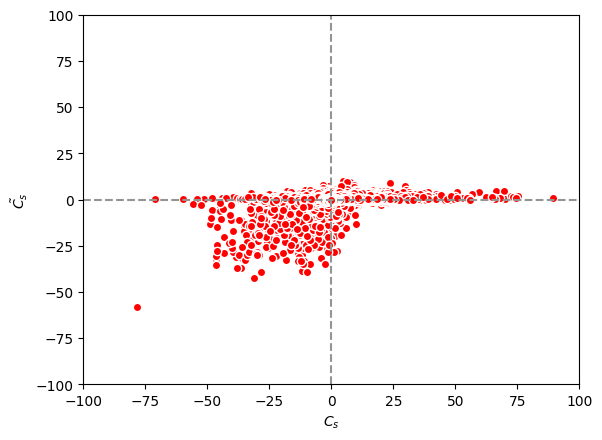

In [104]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation.png')

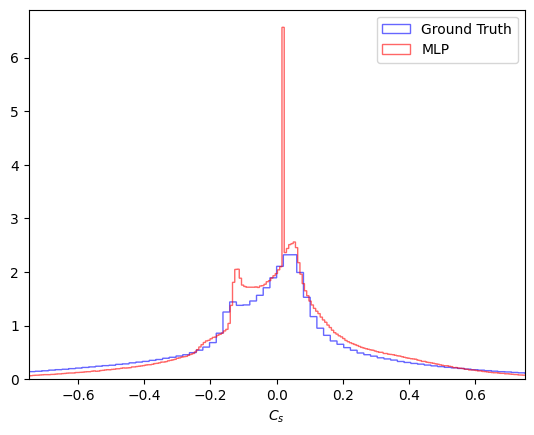

In [105]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density.png')